In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
import random
import timeit
from scipy.signal import savgol_filter
import scipy.stats as st

### Notebook contents:

#### - Data: 
    -isotope ratios measured at intervals down a soil core
    -Each data point has a unique 2SE value associated with analysis
#### - Model:
    - Ranged random number generator is bounded by +/- 2SE for each point
    - Loop produces 1000 depth-profiles, with data points generated by the random generator
    - Each new profile is smoothed into a "smoothed profile" with a cubic polynomial filter
    - Window size of the filter was determined using sum of absolute differences
    - Smoothed dataset is the mean of the simulated profiles
#### - Confidence Intervals:
que pasa?? these are super tight...

In [193]:
Site_01_full = pd.read_csv('US01_full_profile_all_integrations_filtered.csv')
Site_01 = Site_01_full.dropna().reset_index(drop=True)

In [194]:
y = Site_01['depth']
UU = Site_01['U234_U238_CORR']
UTh = Site_01['Th230_U238_CORR']
UUerr = Site_01['U234_U238_CORR_Int2SE']
UTherr = Site_01['Th230_U238_CORR_Int2SE']

In [195]:
UU_min = UU-UUerr
UU_max = UU+UUerr
#U-Th
UTh_min = UTh-UTherr
UTh_max = UTh+UTherr

In [196]:
UU_mc = pd.DataFrame(columns=['depth','UU_obs','UU_min', 'UU_max','UU_rand','UU_smooth','id'])

for e in range(1000):    
    pred_i = random.uniform(UU_min, UU_max) #generate a random data point between +/- 2se of the measurement
    
    temp_runs = pd.DataFrame()
    
    temp_runs['depth']=y
    temp_runs['UU_obs']=UU
    temp_runs['UU_min']=UU_min
    temp_runs['UU_max']=UU_max
    temp_runs['UU_rand']=pred_i
    temp_runs['id']=e
    
    UU_mc = UU_mc.append(pd.DataFrame(data=temp_runs), sort=False)

In [217]:
UTh_mc = pd.DataFrame(columns=['depth','UTh_obs','UTh_min', 'UTh_max','UTh_rand','UTh_smooth','id'])

for e in range(1000):    
    pred_i = random.uniform(UTh_min, UTh_max) #generate a random data point between +/- 2se of the measurement
    
    temp_runs = pd.DataFrame()
    
    temp_runs['depth']=y
    temp_runs['UTh_obs']=UTh
    temp_runs['UTh_min']=UTh_min
    temp_runs['UTh_max']=UTh_max
    temp_runs['UTh_rand']=pred_i
    temp_runs['id']=e
    
    UTh_mc = UTh_mc.append(pd.DataFrame(data=temp_runs), sort=False)

In [218]:
#split by run number before applying the filter
grouped = UU_mc.groupby('id')

for group in grouped:
    smooth_i = savgol_filter(UU_mc.UU_rand, 25, 3) #cubic polynomial filter w a window size of 25

In [219]:
#split by run number before applying the filter
grouped = UTh_mc.groupby('id')

for group in grouped:
    smooth_e = savgol_filter(UTh_mc.UTh_rand, 25, 3) #cubic polynomial filter w a window size of 25

In [220]:
UU_mc['UU_smooth']=smooth_i #add values back to df
UTh_mc['UTh_smooth']=smooth_e #add values back to df

In [221]:
#pivot and remove all but smoothed values to visualize w df.plot
pivot_UU = UU_mc.pivot(index='depth', columns='id')
pivot_UU = pivot_UU['UU_smooth']

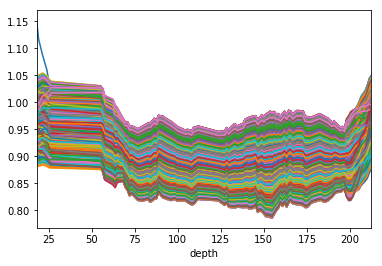

In [222]:
#visualizing all the lines
pivot_UU.plot(kind='line', legend=False)
plt.show()

### Calculating confidence intervals ------------------------------------------------------------------------------------------------

In [227]:
#Calculate the mean and stdeviation of all iterations of the smoothed data
Upop_mean = UU_mc.groupby('depth')['UU_smooth'].mean()
Upop_std = UU_mc.groupby('depth')['UU_smooth'].std()

#U-Th
UThpop_mean = UTh_mc.groupby('depth')['UTh_smooth'].mean()
UThpop_std = UTh_mc.groupby('depth')['UTh_smooth'].std()

    -Standard deviation of model runs at each measurement range from 0.03 - 0.06 
    -The 2SE of the analytical measurements range from 0.03 - 0.18
   
#### Running into a problem here:

In [228]:
#Using scipy.t.interval - student's t-test
#returns the end points of the distrubtion range, 0.95 specified
#st.sem returns the standard error of the input array
ci_95_UU = UU_mc.groupby('depth')['UU_smooth'].apply(lambda x: st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x)))

ci_95_UTh = UTh_mc.groupby('depth')['UTh_smooth'].apply(lambda x: st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x)))

In [234]:
ci_95_UU = ci_95_UU.apply(pd.Series)
low_ci_UU = ci_95_UU.loc[:,0]
high_ci_UU = ci_95_UU.loc[:,1]
buff = high_ci_UU - low_ci_UU
#buff #why is the confidence interval so tight???

In [235]:
ci_95_UTh = ci_95_UTh.apply(pd.Series)
low_ci_UTh = ci_95_UTh.loc[:,0]
high_ci_UTh = ci_95_UTh.loc[:,1]

### PLOTS ------------------------------------------------------------------------------------------------------------------------------------------

In [240]:
U_label = '$^{234}$U/$^{238}$U'
Th_label = '$^{230}$Th/$^{238}$U'

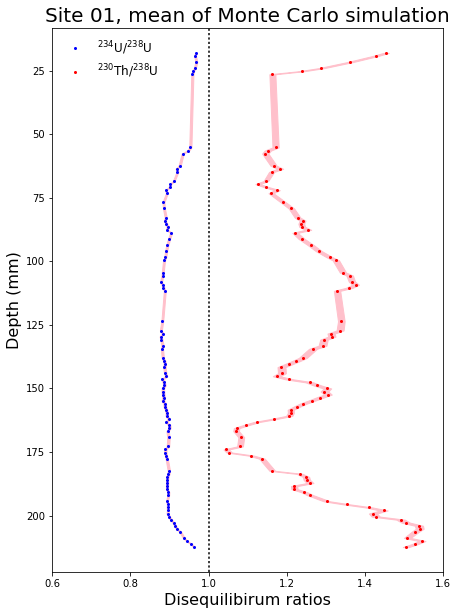

In [248]:
fig, ax = plt.subplots(figsize=(7,10))

ax.fill_betweenx(y, low_ci_UU, high_ci_UU, color='pink')
ax.plot(Upop_mean, y, marker='o', color='b', label=U_label, linestyle='', markersize=2)

ax.fill_betweenx(y, low_ci_UTh, high_ci_UTh, color='pink')
ax.plot(UThpop_mean, y, marker='o', color='r', label=Th_label, linestyle='', markersize=2)

ax.set_ylabel('Depth (mm)', fontsize=16)
ax.invert_yaxis()

ax.set_xlabel('Disequilibirum ratios', fontsize=16)
ax.axvline(x=1, linestyle=':', color='k')
ax.set_xlim(0.6,1.6)

ax.legend(loc='upper left', frameon=False, fontsize=12)
plt.title('Site 01, mean of Monte Carlo simulation', fontsize=20)

plt.show()